<a href="https://colab.research.google.com/github/Nikhil-4-Pal/InsightX-Data-Driven-Employee-Performance-Attrition-Analytics/blob/main/InsightX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn faker
!pip install nltk vaderSentiment transformers
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Generating Dataset

In [ ]:
fake = Faker()

job_roles = ['Software Engineer','Data Scientist','Product Manager','HR Specialist','Sales Executive']
departments = ['Technology','Data Science','Product','Human Resource','Sales']

data = []

for i in range(1000):
  satisfaction = round(random.uniform(1,5),1)
  performance = round(random.uniform(1,5),1)
  attrition_prob = 1 / (1 + np.exp(satisfaction + performance - 6))
  attrition = 1 if random.random() < attrition_prob else 0

  data.append({
      'employeeid':i+100,
      'tenuremonths': random.randint(1,72),
      'monthlypay': random.randint(40000,150000),
      'jobrole': random.choice(job_roles),
      'department':random.choice(departments),
      'satisfactionscore':satisfaction,
      'performancerating': performance,
      'lastreviewtext': fake.paragraph(nb_sentences=3),
      'attrition':attrition
  })

df = pd.DataFrame(data)
df.to_csv('hr_analytics_dataset.csv',index=False)
print(df.head(5))

   employeeid  tenuremonths  monthlypay            jobrole    department  \
0         100            45       93587    Product Manager       Product   
1         101            62       58751      HR Specialist    Technology   
2         102            22       49266     Data Scientist  Data Science   
3         103            33      107508     Data Scientist         Sales   
4         104            34      100386  Software Engineer  Data Science   

   satisfactionscore  performancerating  \
0                4.5                1.2   
1                1.9                2.9   
2                2.7                4.0   
3                2.6                3.3   
4                1.3                3.4   

                                      lastreviewtext  attrition  
0  Money resource because speak wait. Deal black ...          1  
1  Kind remain strong discuss glass six. Can pres...          1  
2  Land event movie floor. Article herself save p...          0  
3  Environmental pie

# EDA and Hypothesis testing

#### Attrition by job roles

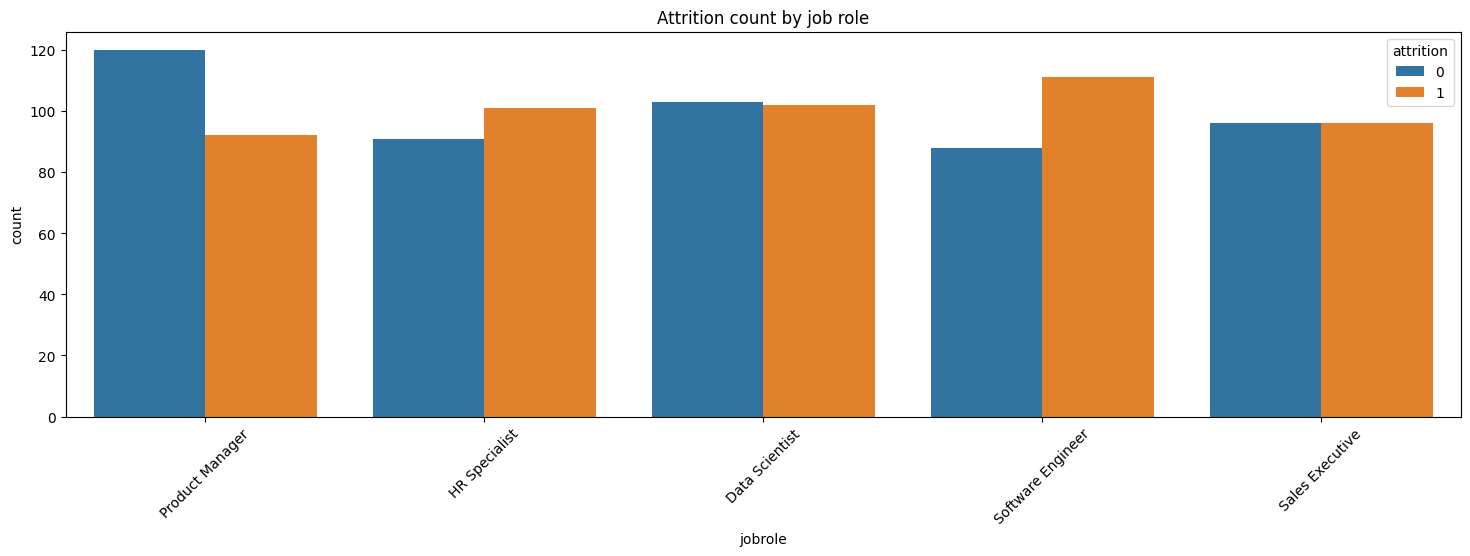

In [ ]:
plt.figure(figsize=(18,5))
sns.countplot(data=df, x='jobrole', hue='attrition')
plt.xticks(rotation=45)
plt.title('Attrition count by job role')
plt.show()

#### Satisfaction vs attrition

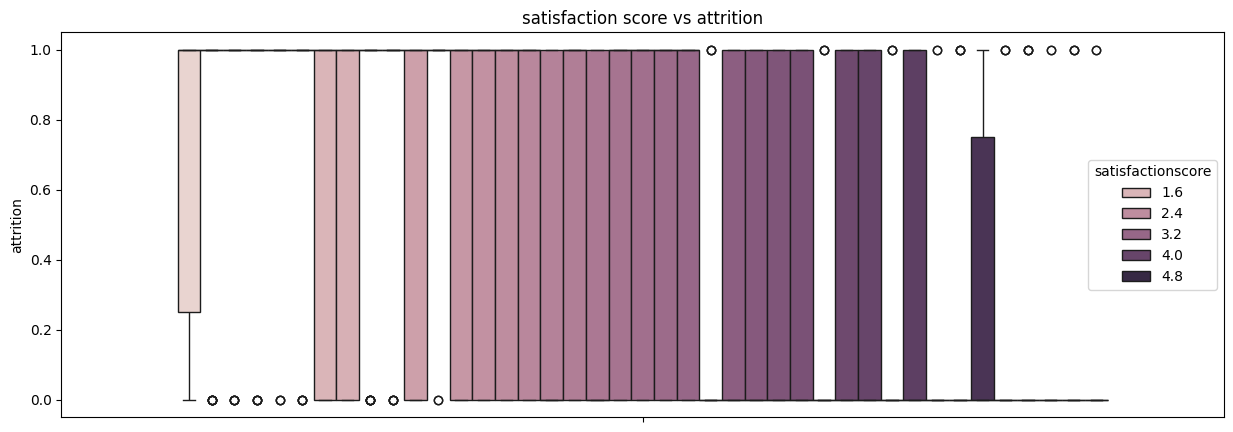

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, y='attrition', hue='satisfactionscore')
plt.title('satisfaction score vs attrition')
plt.show()

#### Performing Hypothesis testing

In [ ]:
from scipy.stats import ttest_ind

attrition_yes = df[df['attrition'] == 1]['satisfactionscore']
attrition_no = df[df['attrition'] == 0]['satisfactionscore']

t_stat, p_value = ttest_ind(attrition_yes, attrition_no, nan_policy='omit')

print(f'p-value:{p_value}]')
if p_value < 0.05:
  print('Result: we reject to null hypothesis satisfaction score is a significant factor in attrition')
else:
  print('Result: we fail to reject the null hypothesis')


p-value:1.0225742292426855e-51]
Result: we reject to null hypothesis satisfaction score is a significant factor in attrition


# Building predictive model

#### feature engineering

In [ ]:
x = df.drop(['employeeid','lastreviewtext','attrition'],axis=1)
y = df['attrition']

categorical_features = ['jobrole','department']
numerical_features = ['tenuremonths','monthlypay','satisfactionscore','performancerating']

preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(), numerical_features),
        ('cat',OneHotEncoder(),categorical_features)
    ]
)

#### Training and evaluating model

In [ ]:
model = Pipeline(steps=[('preprocessor',preprocessor),
                        ('classifier',RandomForestClassifier(n_estimators=180, random_state=55))])

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=55,test_size=0.25, stratify=y)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(f'accuracy:{accuracy_score(y_test, y_pred):.2f}')
print(f'\n Classification report :\n {classification_report(y_test, y_pred)}')

accuracy:0.74

 Classification report :
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       124
           1       0.76      0.71      0.74       126

    accuracy                           0.74       250
   macro avg       0.74      0.74      0.74       250
weighted avg       0.75      0.74      0.74       250



In [ ]:
cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_feature_names])

importances = model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature':all_feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

print('\n Top 5 attrition drivers:')
print(feature_importance_df.head())


 Top 5 attrition drivers:
                  feature  importance
2       satisfactionscore    0.318918
3       performancerating    0.227916
1              monthlypay    0.160157
0            tenuremonths    0.145704
13  department_Technology    0.017054


# Sentiment and burnout analysis

In [ ]:
analyzer = SentimentIntensityAnalyzer()

df['sentimentscore'] = df['lastreviewtext'].apply(lambda text: analyzer.polarity_scores(text)['compound'])
print(df[['lastreviewtext','sentimentscore']].head())

                                      lastreviewtext  sentimentscore
0  Money resource because speak wait. Deal black ...          0.4404
1  Kind remain strong discuss glass six. Can pres...          0.7717
2  Land event movie floor. Article herself save p...          0.4939
3  Environmental piece enter candidate profession...          0.0258
4  Yes citizen stay debate think example others. ...         -0.0772


#### Burnout detection

In [ ]:
burnout_lexicon = {
    'exhaustion': ['exhausted', 'drained', 'fatigued', 'overwhelmed', 'burnt out', 'tired'],
    'cynicism': ['detached', 'disengaged', 'unappreciated', 'negative', 'frustrated', 'stuck'],
    'inefficacy': ['ineffective', 'useless', 'pointless', 'stagnant', 'no impact']
}

def calculate_burnout_risk(text):
  score = 0
  text = text.lower()
  for category in burnout_lexicon:
    for word  in burnout_lexicon[category]:
      if word in text:
        score += 1
  return score

df['burnoutriskscore'] = df['lastreviewtext'].apply(calculate_burnout_risk)

print('\n Employees with highest burnour risk:')
print(df.sort_values(by='burnoutriskscore',ascending=False).head())


 Employees with highest burnour risk:
     employeeid  tenuremonths  monthlypay          jobrole    department  \
999        1099             5      121044   Data Scientist  Data Science   
0           100            45       93587  Product Manager       Product   
1           101            62       58751    HR Specialist    Technology   
2           102            22       49266   Data Scientist  Data Science   
3           103            33      107508   Data Scientist         Sales   

     satisfactionscore  performancerating  \
999                2.5                1.3   
0                  4.5                1.2   
1                  1.9                2.9   
2                  2.7                4.0   
3                  2.6                3.3   

                                        lastreviewtext  attrition  \
999   Rather foreign fish compare. Them on in whether.          1   
0    Money resource because speak wait. Deal black ...          1   
1    Kind remain strong di

In [ ]:
def calculate_retention_roi(predicted_leavers_df, intervention_cost_per_employee, retention_success_rate):
    avg_turnover_cost = (predicted_leavers_df['monthlypay'] * 12 * 0.75).mean()

    num_at_risk = len(predicted_leavers_df)
    employees_saved = round(num_at_risk * retention_success_rate)
    cost_of_attrition_avoided = employees_saved * avg_turnover_cost
    total_intervention_cost = num_at_risk * intervention_cost_per_employee
    net_benefit = cost_of_attrition_avoided - total_intervention_cost
    roi = (net_benefit / total_intervention_cost) if total_intervention_cost > 0 else 0

    print(f"Number of At-Risk Employees Identified: {num_at_risk}")
    print(f"Average Cost per Turnover: ${avg_turnover_cost:,.2f}")
    print(f"Total Intervention Cost: ${total_intervention_cost:,.2f}")
    print(f"Value of Attrition Avoided: ${cost_of_attrition_avoided:,.2f}")
    print(f"Net Financial Benefit: ${net_benefit:,.2f}")
    print(f"Retention Program ROI: {roi:.2%}")

df['prediction'] = model.predict(x)
at_risk_employees = df[df['prediction'] == 1]
calculate_retention_roi(
    predicted_leavers_df=at_risk_employees,
    intervention_cost_per_employee=500,
    retention_success_rate=0.40
)

Number of At-Risk Employees Identified: 494
Average Cost per Turnover: $850,275.89
Total Intervention Cost: $247,000.00
Value of Attrition Avoided: $168,354,626.76
Net Financial Benefit: $168,107,626.76
Retention Program ROI: 68059.77%
